In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(cowplot))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(harmony))
suppressMessages(library(ArchR))

In [2]:
out_dir <- "../../results/10_stereo_seq/07_integrate_with_scrna"

if(!dir.exists(out_dir)){
    dir.create(out_dir)
}

In [3]:
obj.rna <- readRDS("../../results/03_integrate_scrna/integrated.rds")

In [4]:
obj.rna <- obj.rna %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



In [5]:
obj.rna

An object of class Seurat 
15275 features across 95898 samples within 1 assay 
Active assay: RNA (15275 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

In [6]:
obj.rna <- RunUMAP(obj.rna, 
                   reduction = "harmony", dims = 1:30, 
                   reduction.name = "umap_harmony", verbose = FALSE,
                   return.model = TRUE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [7]:
cols <- c("B cells" = "#1f77b4",
          "Endothelial" = "#ff7f0e",
          "Fibroblasts" = "#279e68",
          "Keratinocytes" = "#d62728",
          "Langerhans cells" = "#aa40fc",
          "Macrophages" = "#8c564b",
          "Mast cells" = "#e377c2",
          "Melanocytes" = "#b5bd61",
          "Monocytes" = "#17becf",
          "NK cells" = "#aec7e8",
          "Neural" = "#ffbb78",
          "Pericytes" = "#98df8a",
          "Plasma cells" = "#ff9896",
          "Secretory cells" = "#c5b0d5",
          "Smooth Muscle" = "#c49c94",
          "T cells" = "#f7b6d2",
          "cDC" = "#dbdb8d",
          "pDC" = "#9edae5")

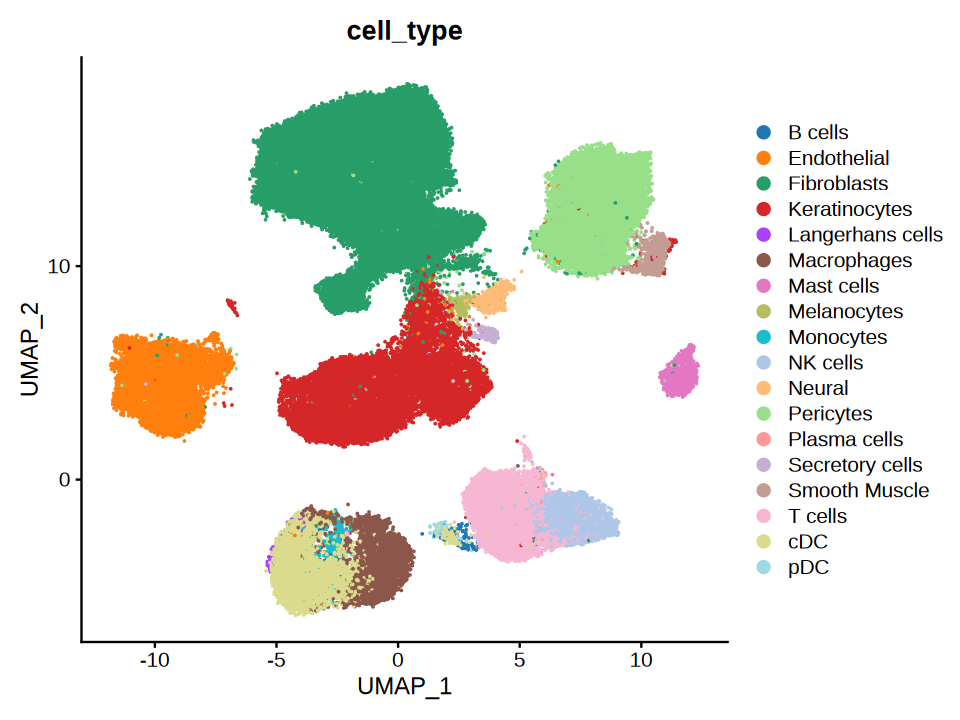

In [8]:
options(repr.plot.height = 6, repr.plot.width = 8)

# cols <- ArchR::paletteDiscrete(obj.rna@meta.data$cell_type)

DimPlot(obj.rna, reduction = "umap", group.by = "cell_type", cols = cols)

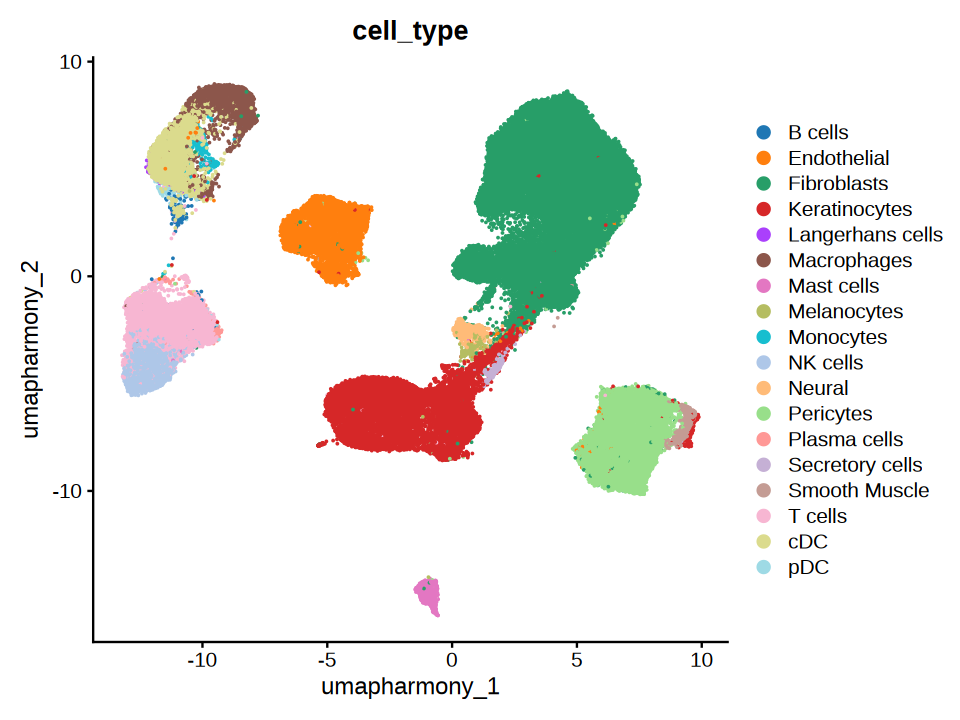

In [9]:
options(repr.plot.height = 6, repr.plot.width = 8)

DimPlot(obj.rna, reduction = "umap_harmony", group.by = "cell_type", cols = cols)

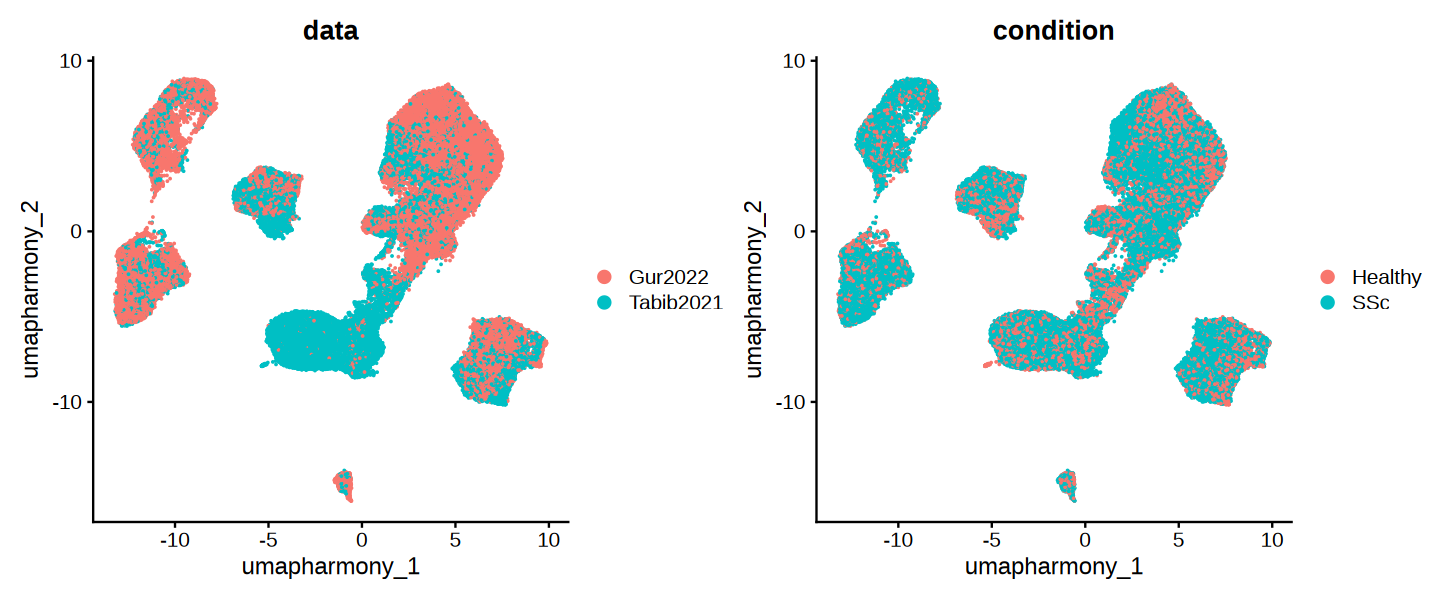

In [10]:
options(repr.plot.height = 5, repr.plot.width = 12)

DimPlot(obj.rna, reduction = "umap_harmony", 
        group.by = c("data", "condition"), shuffle = TRUE)

In [11]:
obj.spatial <- readRDS("../../results/10_stereo_seq/05_anndata_to_seurat/integrated.rds")

In [12]:
obj.spatial

An object of class Seurat 
13649 features across 40566 samples within 1 assay 
Active assay: RNA (13649 features, 0 variable features)
 1 layer present: counts
 1 image present: image

In [13]:
obj.spatial <- obj.spatial %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData() %>%
    RunPCA(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



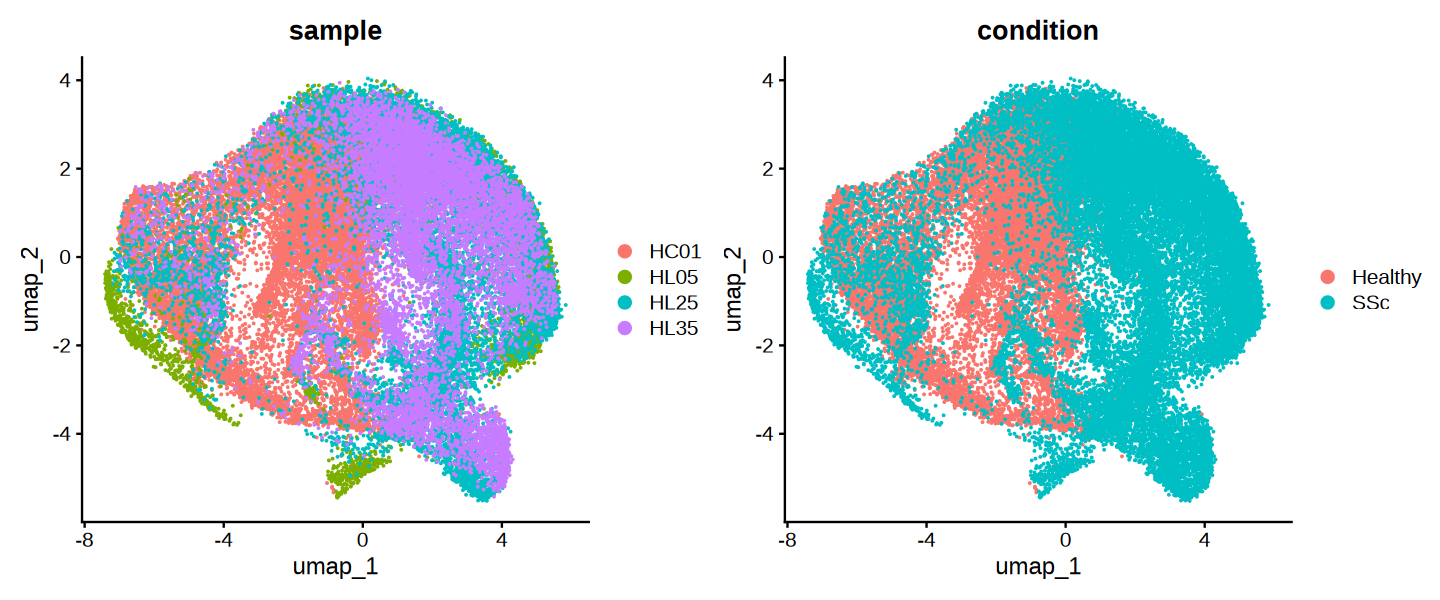

In [14]:
options(repr.plot.height = 5, repr.plot.width = 12)

DimPlot(obj.spatial, group.by = c("sample", "condition"))

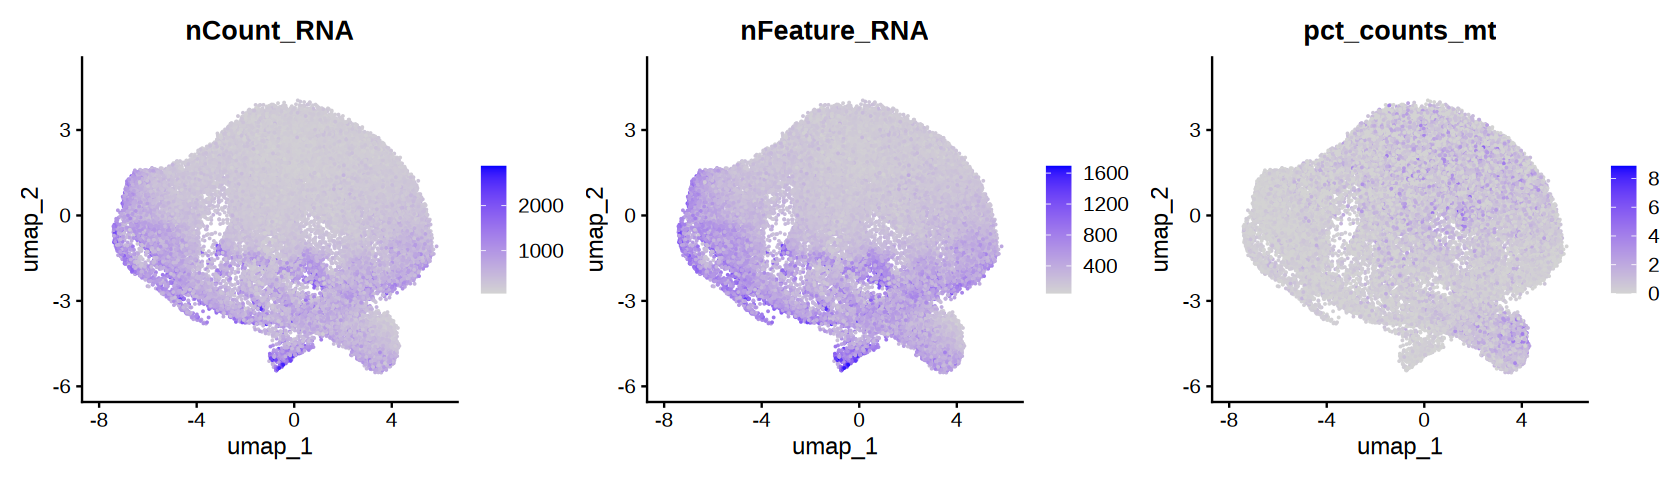

In [15]:
options(repr.plot.height = 4, repr.plot.width = 14)

FeaturePlot(obj.spatial, features = c("nCount_RNA", "nFeature_RNA", "pct_counts_mt"), ncol = 3)

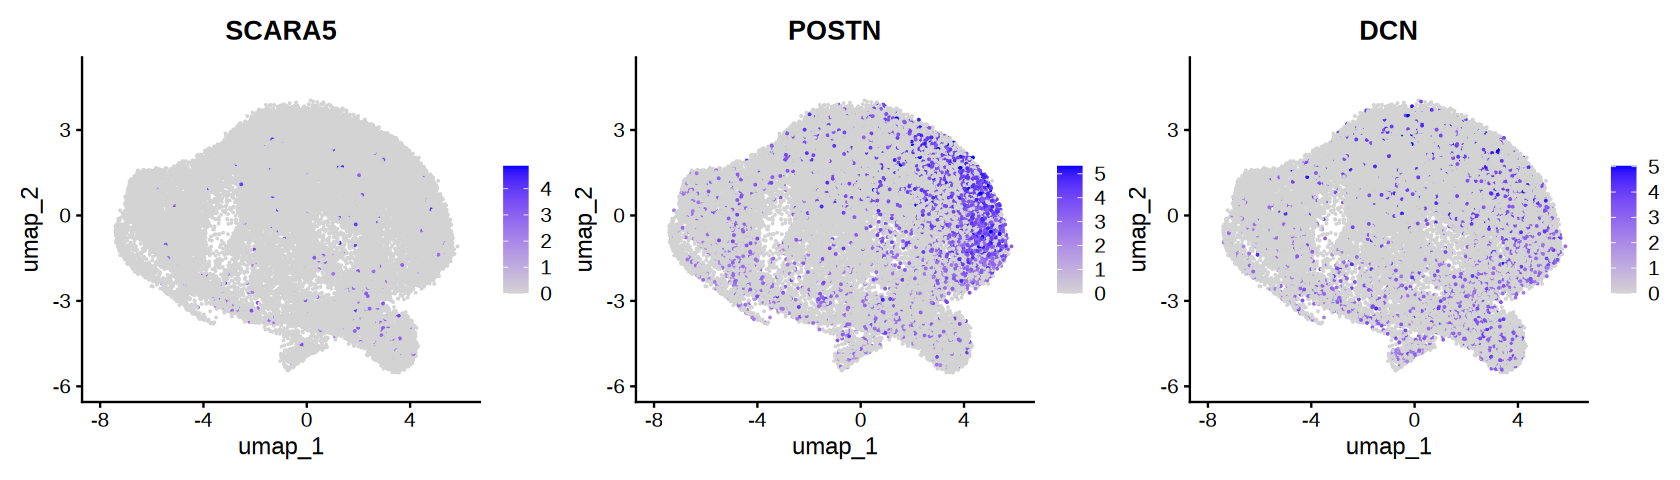

In [16]:
options(repr.plot.height = 4, repr.plot.width = 14)

FeaturePlot(obj.spatial, features = c("SCARA5", "POSTN", "DCN"), ncol = 3, max.cutoff = "q99")

In [17]:
obj.spatial <- RunHarmony(obj.spatial, 
                          group.by.vars = "sample",
                          reduction.use = "pca", 
                          max_iter = 30, 
                          dims.use = 1:30)

obj.spatial <- RunUMAP(obj.spatial, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony",
               reduction.ke = 'umapharmony_',
              verbose = FALSE)

Transposing data matrix

Initializing state using k-means centroids initialization

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2028300)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2028300)”
Harmony 1/30

Harmony 2/30

Harmony 3/30

Harmony converged after 3 iterations



In [18]:
obj.spatial

An object of class Seurat 
13649 features across 40566 samples within 1 assay 
Active assay: RNA (13649 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony
 1 image present: image

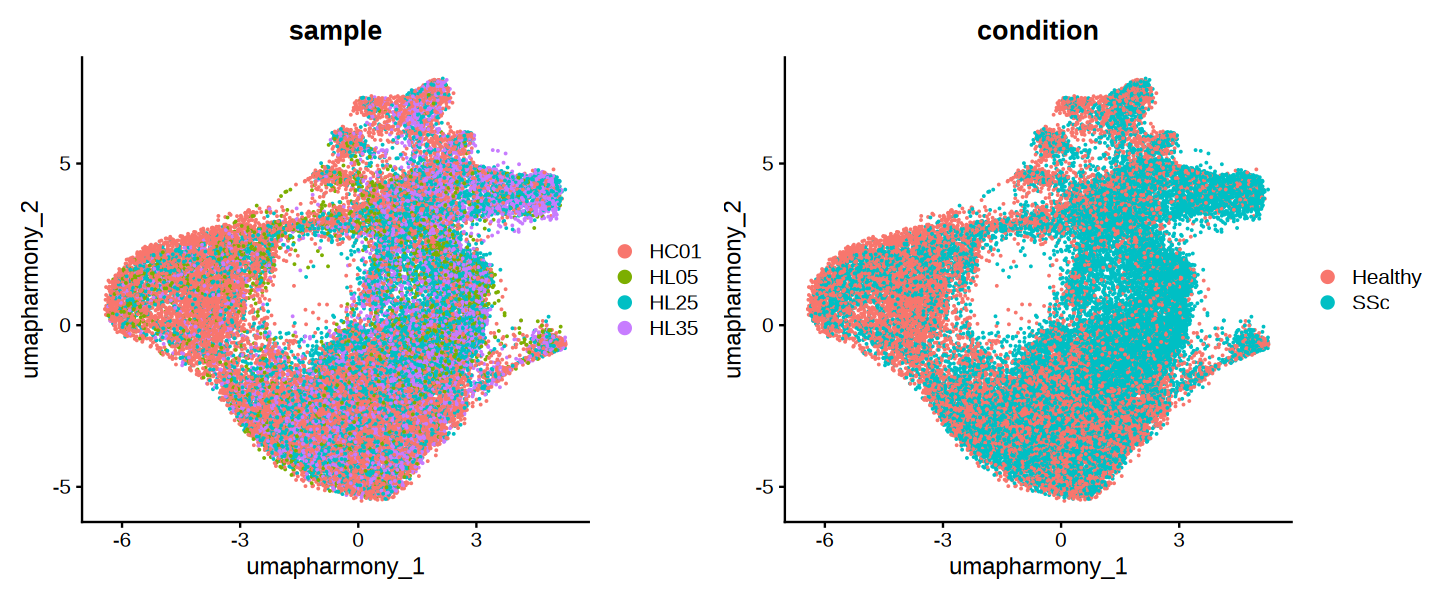

In [19]:
options(repr.plot.height = 5, repr.plot.width = 12)

DimPlot(obj.spatial, group.by = c("sample", "condition"), 
        reduction = "umap_harmony", shuffle = TRUE)

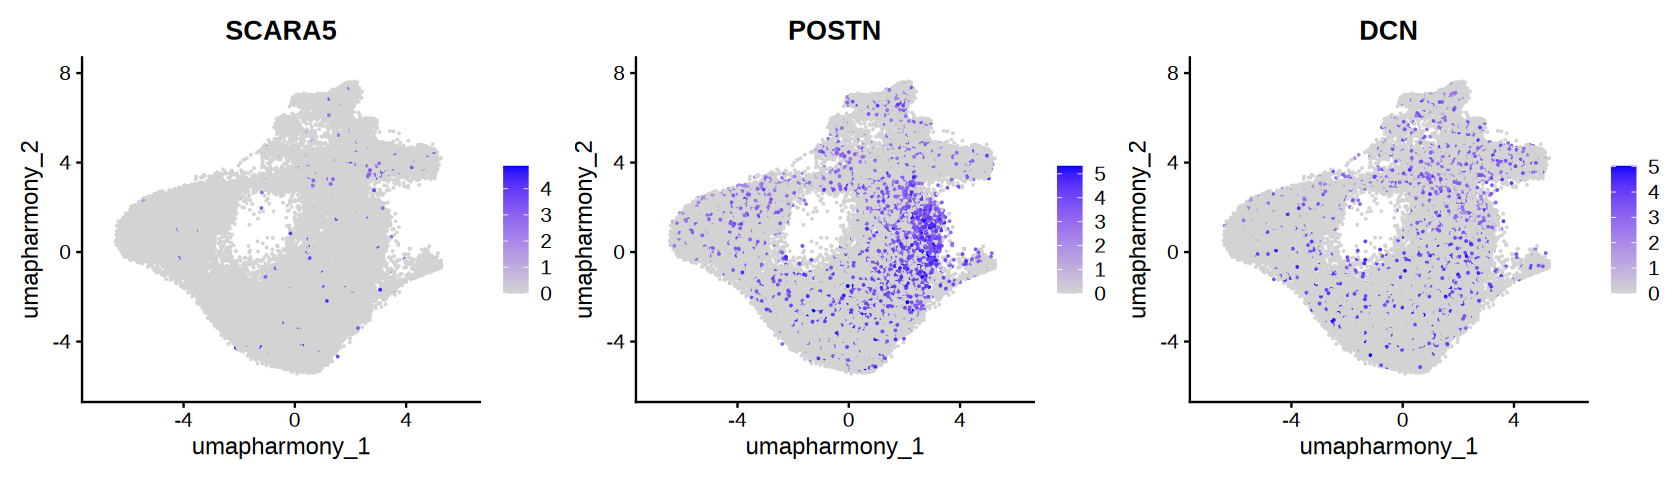

In [20]:
options(repr.plot.height = 4, repr.plot.width = 14)

FeaturePlot(obj.spatial, features = c("SCARA5", "POSTN", "DCN"), ncol = 3, max.cutoff = "q99",
           reduction = "umap_harmony")

In [21]:
features <- intersect(rownames(obj.rna), rownames(obj.spatial))

length(features)

[1] 11110

In [22]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = obj.rna, 
                                        query = obj.spatial, 
                                        features = features,
                                        reference.assay = "RNA", 
                                        query.assay = "RNA", 
                                        reduction = "cca")

Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 67777 anchors



In [23]:
celltype.predictions <- TransferData(anchorset = transfer.anchors, 
                                     refdata = obj.rna$cell_type,
                                     weight.reduction = "cca", 
                                     dims = 1:30)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [24]:
obj.spatial <- AddMetaData(obj.spatial, metadata = celltype.predictions)

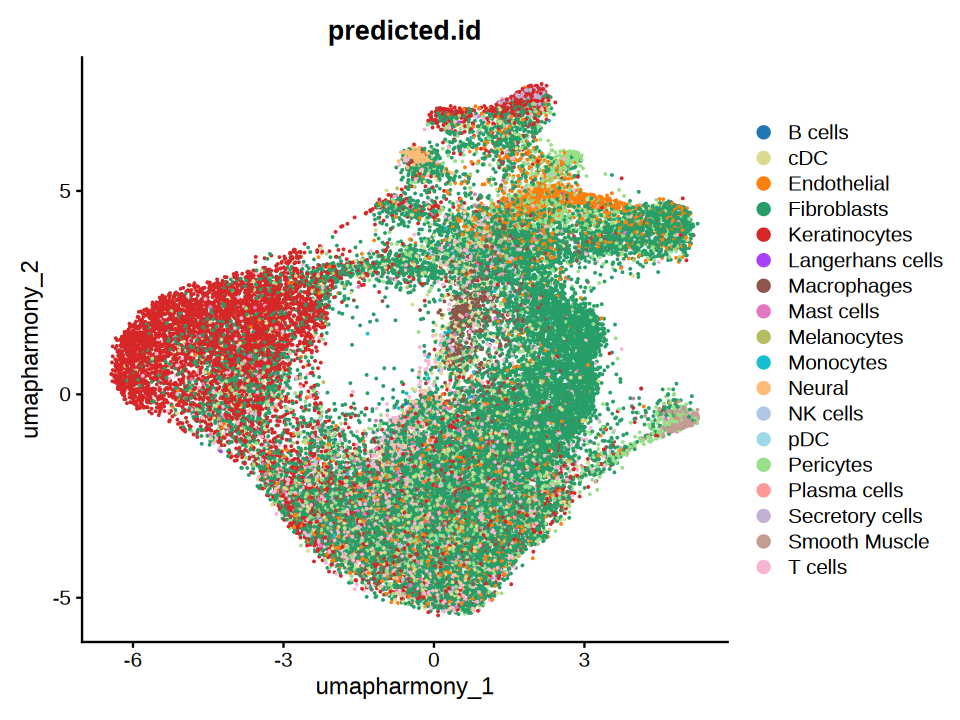

In [25]:
options(repr.plot.height = 6, repr.plot.width = 8)

DimPlot(obj.spatial, group.by = "predicted.id", cols = cols, reduction = "umap_harmony")

In [26]:
# we transfer the harmony embedding from scRNA to spatial data
refdata <- t(obj.rna@reductions$harmony@cell.embeddings)

imputation <- TransferData(anchorset = transfer.anchors, 
                           refdata = refdata, 
                           weight.reduction = "cca",
                           dims = 1:30)

Finding integration vectors

Finding integration vector weights

Transfering 50 features onto reference data

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [27]:
# create new cell embedding
rownames(imputation@data) <- rownames(refdata)
cell.embeddings <- t(cbind(refdata, imputation@data))

In [28]:
obj.rna@meta.data$tech <- "scRNA-seq"
obj.spatial@meta.data$tech <- "Stereo-seq"
obj.spatial@meta.data$cell_type <- obj.spatial@meta.data$predicted.id

In [29]:
coembed <- merge(x = obj.rna, y = obj.spatial, merge.data = FALSE)
coembed <- JoinLayers(coembed)

In [30]:
coembed <- NormalizeData(coembed)

Normalizing layer: counts



In [31]:
coembed

An object of class Seurat 
17814 features across 136464 samples within 1 assay 
Active assay: RNA (17814 features, 2000 variable features)
 3 layers present: scale.data, data, counts
 1 image present: image

In [32]:
# add embedding to merged object
coembed[["harmony"]] <- CreateDimReducObject(embeddings = as.matrix(cell.embeddings), 
                                             key = "Harmony_", assay = "RNA")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



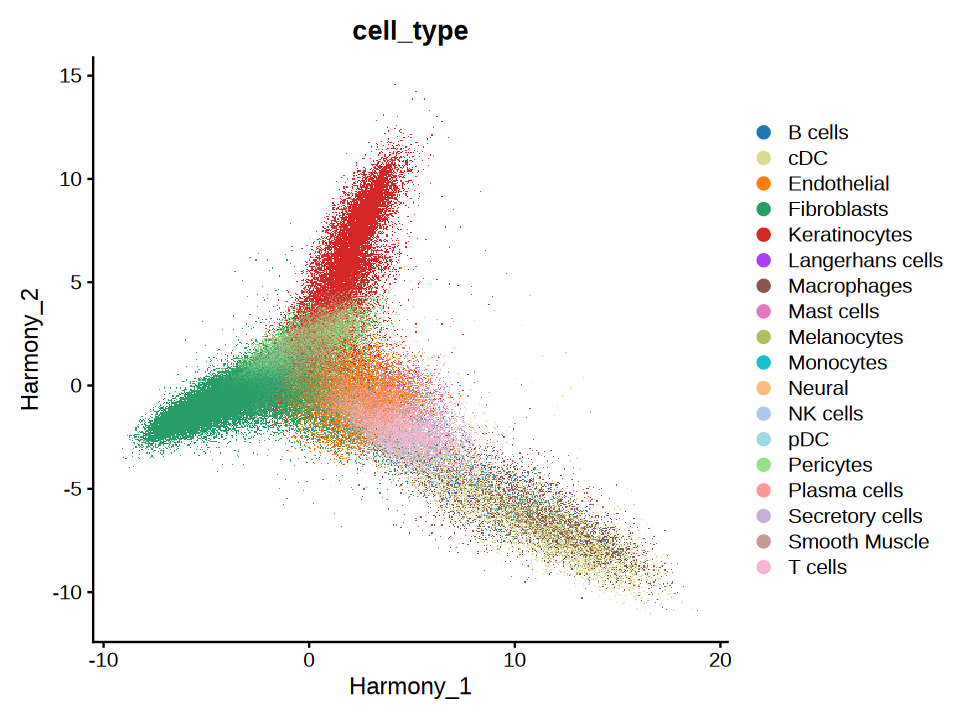

In [33]:
options(repr.plot.height = 6, repr.plot.width = 8)

DimPlot(coembed, group.by = "cell_type", cols = cols, reduction = "harmony")

In [34]:
coembed <- RunUMAP(coembed, dims = 1:20, verbose = FALSE, 
                   reduction = "harmony", reduction.name = "umap_harmony")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



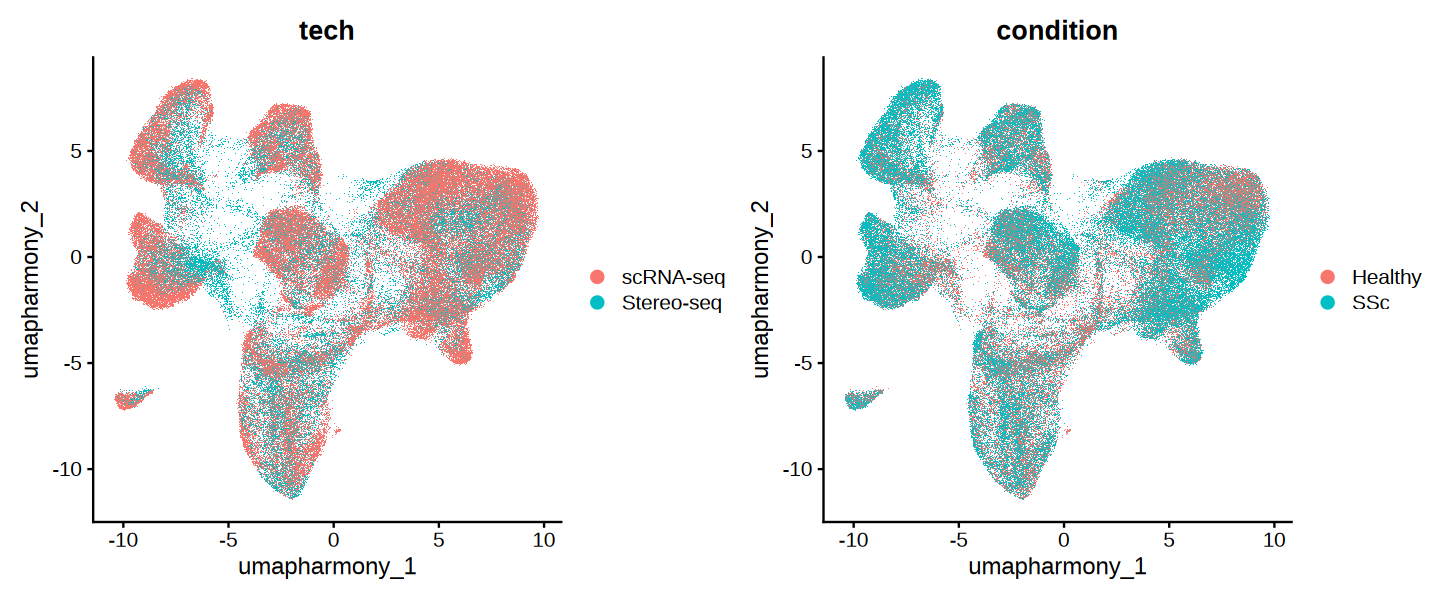

In [35]:
options(repr.plot.height = 5, repr.plot.width = 12)

DimPlot(coembed, group.by = c("tech", "condition"), reduction = "umap_harmony")

Warning message in SetQuantile(cutoff = max.cutoff[f], data = data.feature):
“NAs introduced by coercion”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



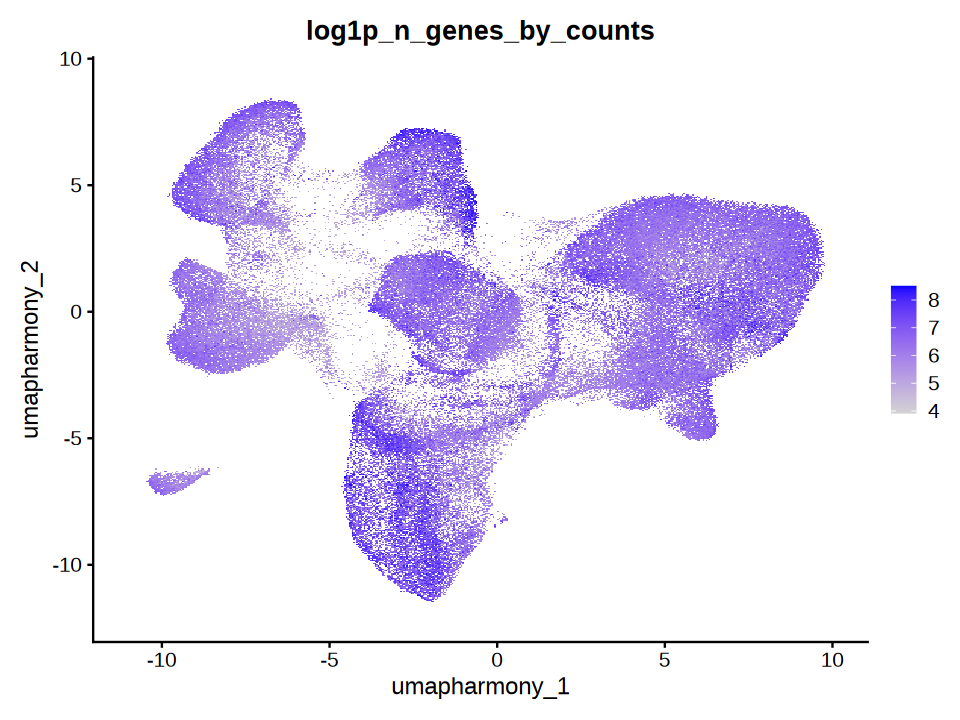

In [36]:
options(repr.plot.height = 6, repr.plot.width = 8)

FeaturePlot(coembed, features = "log1p_n_genes_by_counts", 
            reduction = "umap_harmony", max.cutoff = "p99", min.cutoff = 2)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



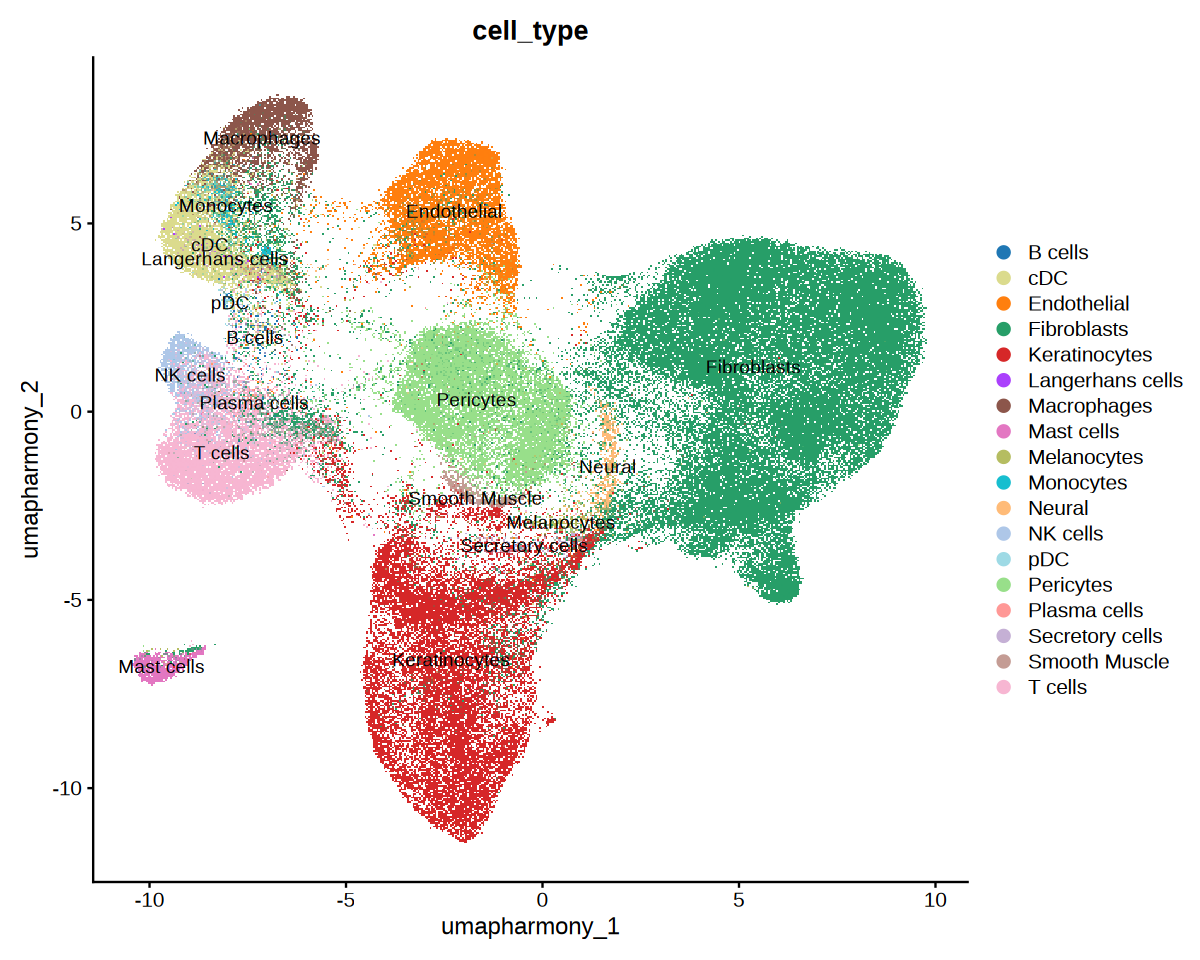

In [37]:
options(repr.plot.height = 8, repr.plot.width = 10)

DimPlot(coembed, group.by = "cell_type", 
        cols = cols, reduction = "umap_harmony", label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



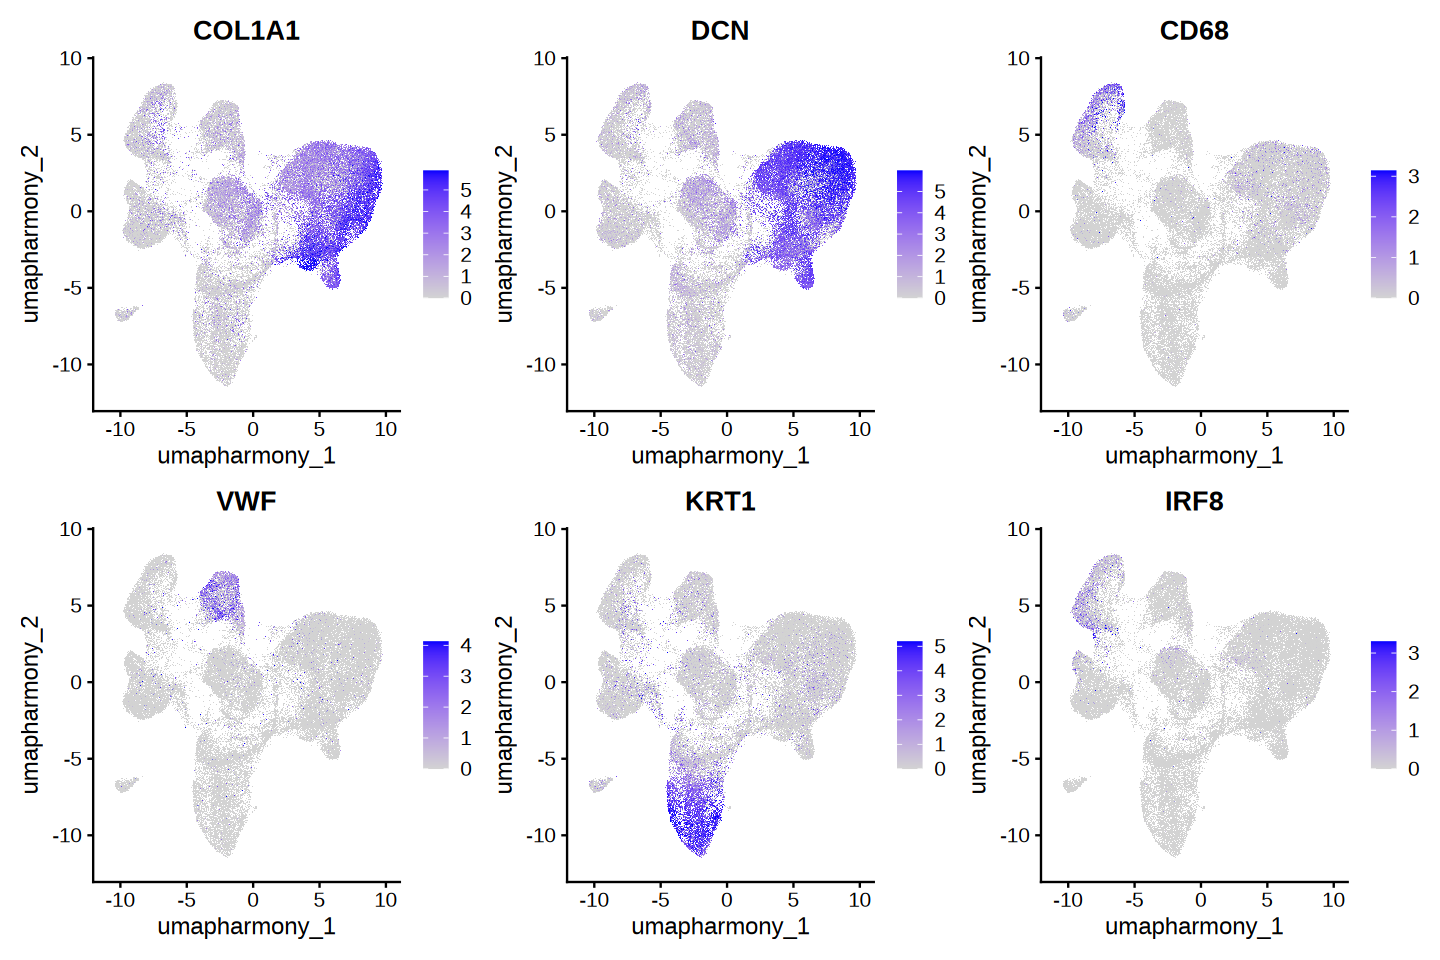

In [43]:
options(repr.plot.height = 8, repr.plot.width = 12)

FeaturePlot(coembed, features = c("COL1A1", "DCN", "CD68", "VWF", "KRT1", "IRF8"), 
            reduction = "umap_harmony", max.cutoff = "q95", ncol = 3)

In [39]:
saveRDS(obj.rna, glue::glue("{out_dir}/rna.rds"))
saveRDS(obj.spatial, glue::glue("{out_dir}/spatial.rds"))
saveRDS(coembed, glue::glue("{out_dir}/coembed.rds"))

In [40]:
write.csv(obj.spatial@meta.data, glue::glue("{out_dir}/spatial.csv"))